![Wine Turbine](https://www.solarfeeds.com/mag/wp-content/uploads/2019/10/picspree-1256331.jpg)

Energi terbarukan, khususnya dari kincir angin, memainkan peran penting dalam transisi menuju sumber energi berkelanjutan. Dengan semakin meningkatnya kebutuhan energi dan kekhawatiran tentang perubahan iklim, penting untuk memanfaatkan teknologi yang ada untuk memprediksi dan mengoptimalkan hasil energi dari sumber ini.

Proyek ini bertujuan untuk menganalisis dan memprediksi energi yang dihasilkan oleh kincir angin menggunakan dataset yang berisi data SCADA (Supervisory Control and Data Acquisition) dari kincir angin di Turki pada tahun 2018.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Data Understanding

columns:
- Date/Time: Stempel waktu yang mencatat tanggal dan waktu pengukuran dengan interval 10 menit.
- LV ActivePower (kW): Energi yang dihasilkan turbin yang menjadi variabel target
- Wind Speed (m/s): Kecepatan angin yang digunakan turbin untuk menghasilkan listrik
- Wind Direction (degrees): Arah angin yang diukur dalam derajat, membantu dalam memahami bagaimana orientasi kincir angin sehingga berpengaruh terhadap efisiensi.
- Theoretical_Power_Curve (KWh): Prediksi energi yang dihasilkan turbin secara teoritis.

data source:

In [2]:
data = pd.read_csv('wind_turbine_scada_dataset.csv')
data.head()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [4]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format="%d %m %Y %H:%M")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


#### Missing Data

In [5]:
print(data.isna().sum())

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


#### Outlier

In [6]:
data.describe()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684332          7.557952   
min              2018-01-01 00:00:00            -2.471405          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00          3618.732910         25.206011   
std                              NaN          1312.459242          4.227166   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
count                   50530.000000        50530.000000  
mean                     1492.175463          123.687559  
min                         0.000000            0.000000  
25%                       161.328167           49.315437  
50%                      1063.776283           73.712978  
75%                      2964.972462          201.696720  
max                      3600.000000          359.997589  
std                      1368.018238           93.443736

terlihat pada kolom LV ActivePower (kW) terdapat nilai yang anomali yaitu berupa bilangan negatif

In [7]:
sum(data["LV ActivePower (kW)"] < 0)

57

Dilakukan penggantian nilai menjadi 0 pada nilai yang negatif karena tidak mungkin pengukuran energi yang dihasilkan menghasilkan nilai negatif

In [8]:
data["LV ActivePower (kW)"] = data["LV ActivePower (kW)"].apply(lambda x: 0 if x < 0 else x)

In [9]:
data.describe()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684699          7.557952   
min              2018-01-01 00:00:00             0.000000          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00          3618.732910         25.206011   
std                              NaN          1312.458876          4.227166   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
count                   50530.000000        50530.000000  
mean                     1492.175463          123.687559  
min                         0.000000            0.000000  
25%                       161.328167           49.315437  
50%                      1063.776283           73.712978  
75%                      2964.972462          201.696720  
max                      3600.000000          359.997589  
std                      1368.018238           93.443736

#### Feature Engineering

In [10]:
# ekstraksi date/time ke hour, day, week, mounth
data['Week'] = data['Date/Time'].dt.isocalendar().week
data['Month'] = data['Date/Time'].dt.month
data['Hour'] = data['Date/Time'].dt.hour
data['Day'] = data['Date/Time'].dt.day
data.sample(3)

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
6685  2018-02-20 22:00:00             0.000000          3.359682   
15880 2018-04-25 21:10:00           466.132812          5.938964   
19621 2018-05-21 22:40:00          1458.665039          8.139731   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  Week  Month  Hour  \
6685                       37.859523           83.337479     8      2    22   
15880                     604.590751           67.534157    17      4    21   
19621                    1611.001516           70.247200    21      5    22   

       Day  
6685    20  
15880   25  
19621   21

In [11]:
# Melihat musim
def get_season(month):
    if month in [12, 1, 2]:
        return 1 # Winter
    elif month in [3, 4, 5]:
        return 2 #Spring
    elif month in [6, 7, 8]:
        return 3 #Summer
    else:
        return 4 #Autumn

data['Season'] = data['Month'].apply(get_season)
data.sample(3)

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
44444 2018-11-19 14:50:00          1224.640015          7.208144   
37175 2018-09-21 18:40:00          1073.302979          7.125774   
41335 2018-10-25 06:30:00          3429.601074         12.629330   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  Week  Month  Hour  \
44444                    1112.508683          204.255005    47     11    14   
37175                    1073.627213           84.410622    38      9    18   
41335                    3587.531075          344.497803    43     10     6   

       Day  Season  
44444   19       4  
37175   21       4  
41335   25       4

##### Identifikasi siang/malam (Day/Night).

Berdasarkan data peta angin di Turki (https://globalwindatlas.info/en/area/Turkey), daerah yang memiliki kecepatan angin tinggi (lebih dari 10m/s), sesuai dengan data, yaitu daerah Izmir.

Untuk itu digunakan library Astral untuk mengetahui waktu terbit dan tenggelamnya matahari di lokasi Izmir dan menentukan siang dan malam.

In [ ]:
!pip install astral pytz


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from astral import LocationInfo
from astral.sun import sun
import pytz

location = LocationInfo("Izmir", "Turkey", "Europe/Istanbul", 38.4192, 27.1287)
def day_or_night(dt):

    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
    dt = dt.tz_localize('Europe/Istanbul')
    if sunrise < dt < sunset:
            return 0 # Day
    else:
            return 1 # Night.
data['Day/Night'] = data['Date/Time'].apply(day_or_night)
data.head()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  Week  Month  Hour  Day  \
0                     416.328908          259.994904     1      1     0    1   
1                     519.917511          268.641113     1      1     0    1   
2                     390.900016          272.564789     1      1     0    1   
3                     516.127569          271.258087     1      1     0    1   
4                     491.702972          265.674286     1      1     0    1   

   Season  Day/Night  
0       1          1  
1       1          1  
2       1          1  
3       1          1  
4       1          1

##### Temperature

Melalui prinsip **Energi Kinetik Angin** dengan rumus:
$$
   P{turbine} = \frac{1}{2} * ρAv^3
$$
Dimana:
- $  P{turbine} $ = daya yang dihasilkan oleh turbin angin.
- ρ = densitas udara (kg/m³).
- A = area penampang turbin (m²).
- v = kecepatan angin (m/s).

serta **Hukum Gas Ideal** dengan rumus:
$$
   ρ α \frac{1}{T}
$$
Dimana:
ρ = densitas udara (kg/m³).
T = suhu mutlak dalam Kelvin (K).


Maka dapat disimpulkan terdapat hubungan antara suhu, kecepatan angin, dan energi kinetik dari angin.   

Proses penghitungan dilakukan menggunakan library **meteostat** yang menyimpan data cuaca dan suhu.

In [14]:
!pip install meteostat


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from meteostat import Point, Hourly

location = Point(38.4192, 27.1287) #menggunakan data lokasi daerah Izmir
start = data['Date/Time'].min()
end = data['Date/Time'].max()

data_weather = Hourly(location, start, end)
data_weather = data_weather.fetch()
data_weather.index = data_weather.index.tz_localize(None)
#resample to 10 minute interval
data_weather = data_weather.resample('10min').ffill()
data_weather.reset_index(inplace=True)
data_weather = data_weather[['time','temp']]
data_weather = data_weather.rename(columns={'time': 'Date/Time', 'temp': 'Temperature (°C)'})
data_weather.head()

Date/Time  Temperature (°C)
0 2018-01-01 00:00:00               2.0
1 2018-01-01 00:10:00               2.0
2 2018-01-01 00:20:00               2.0
3 2018-01-01 00:30:00               2.0
4 2018-01-01 00:40:00               2.0

In [16]:
data = pd.merge(data, data_weather, on='Date/Time', how='left')
data.head()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  Week  Month  Hour  Day  \
0                     416.328908          259.994904     1      1     0    1   
1                     519.917511          268.641113     1      1     0    1   
2                     390.900016          272.564789     1      1     0    1   
3                     516.127569          271.258087     1      1     0    1   
4                     491.702972          265.674286     1      1     0    1   

   Season  Day/Night  Temperature (°C)  
0       1          1               2.0  
1       1          1               2.0  
2       1          1               2.0  
3       1          1               2.0  
4       1          1               2.0

In [17]:
print(data['Temperature (°C)'].isna().sum())

17


Dilakukan pengisian data yang hilang dengan cara interpolasi

In [18]:
data['Temperature (°C)'] = data['Temperature (°C)'].interpolate()

In [19]:
print(data['Temperature (°C)'].isna().sum())

0


#### EDA and Visualisasi

In [20]:
data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Week', 'Month',
       'Hour', 'Day', 'Season', 'Day/Night', 'Temperature (°C)'],
      dtype='object')

In [21]:
observed_columns = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Temperature (°C)']

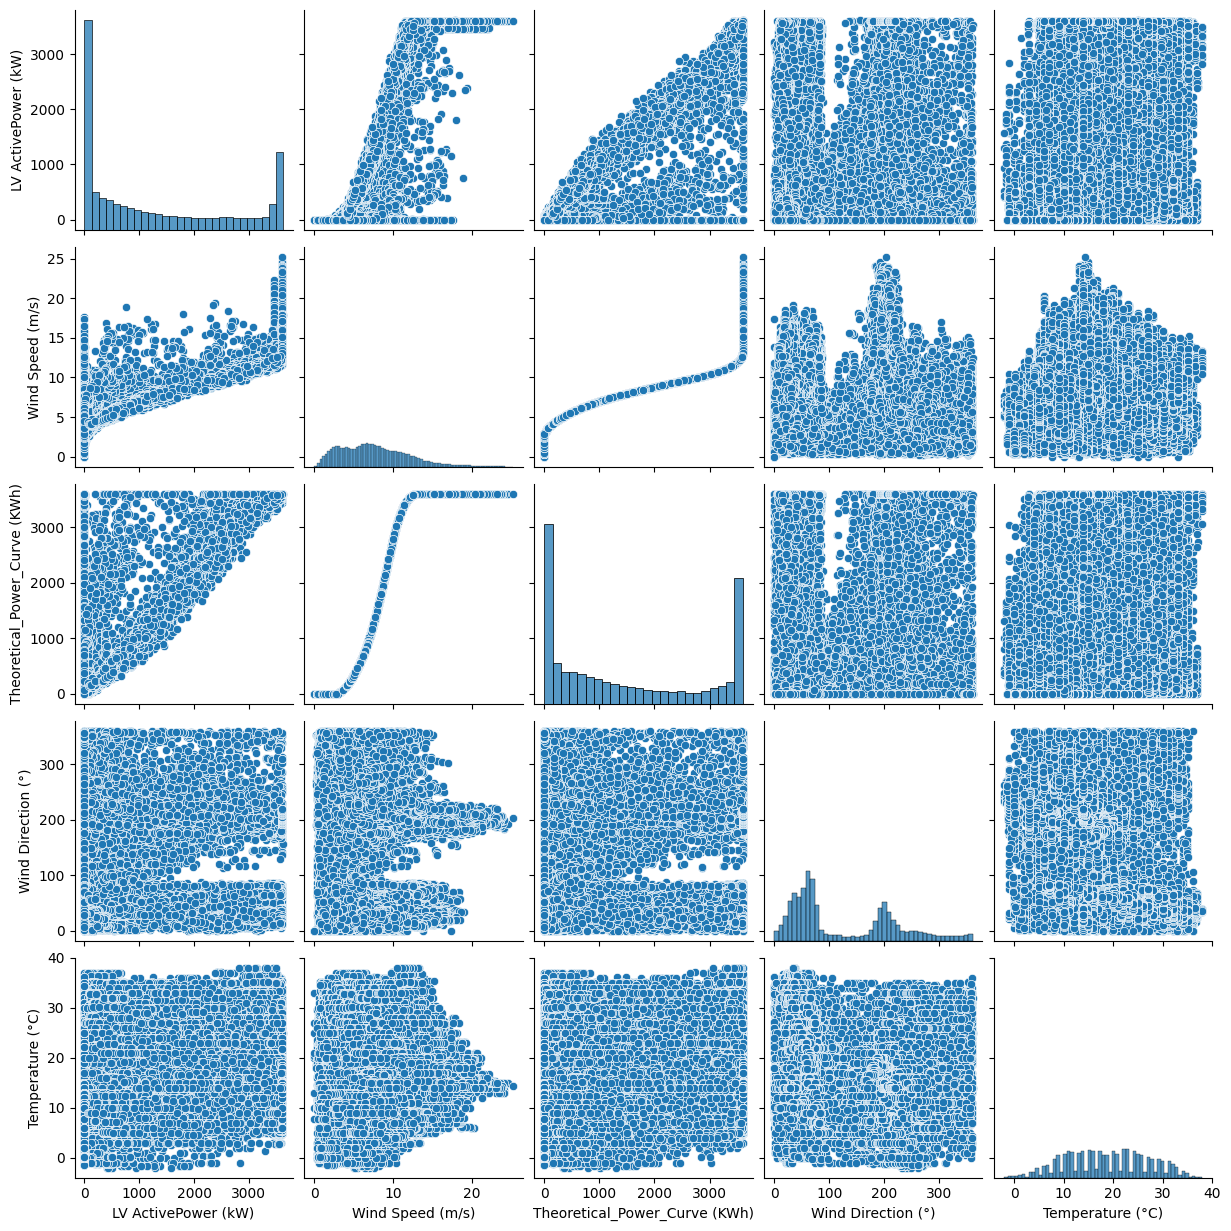

In [22]:
sns.pairplot(data[observed_columns])
plt.show()

array([[<Axes: title={'center': 'LV ActivePower (kW)'}>,
        <Axes: title={'center': 'Wind Speed (m/s)'}>],
       [<Axes: title={'center': 'Theoretical_Power_Curve (KWh)'}>,
        <Axes: title={'center': 'Wind Direction (°)'}>],
       [<Axes: title={'center': 'Temperature (°C)'}>, <Axes: >]],
      dtype=object)

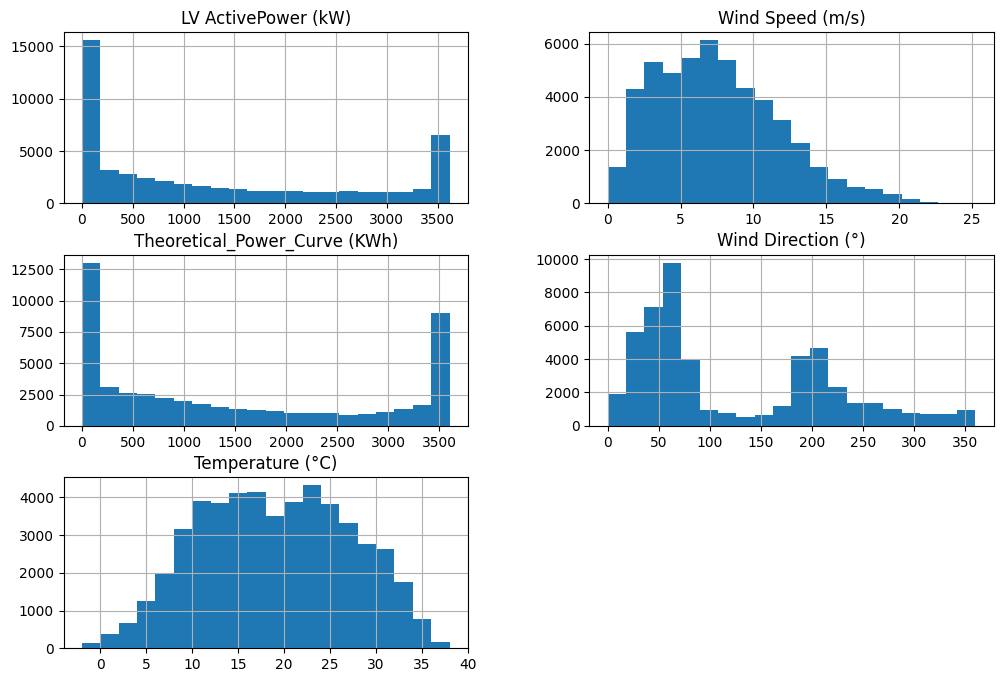

In [23]:
data[observed_columns].hist(bins =20, figsize=(12,8))

##### box plot

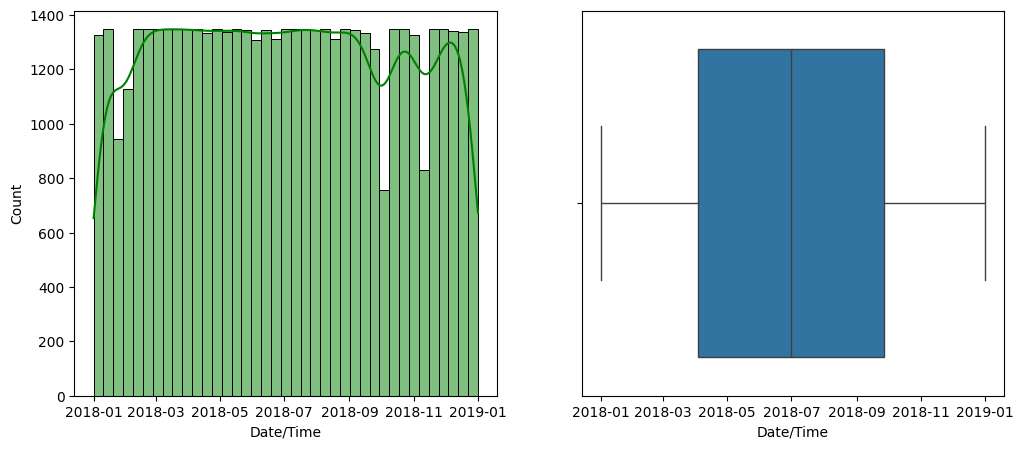

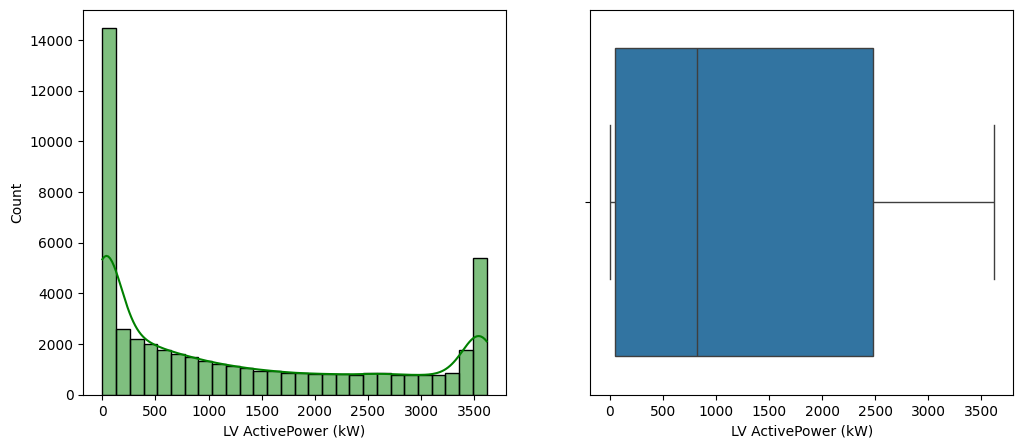

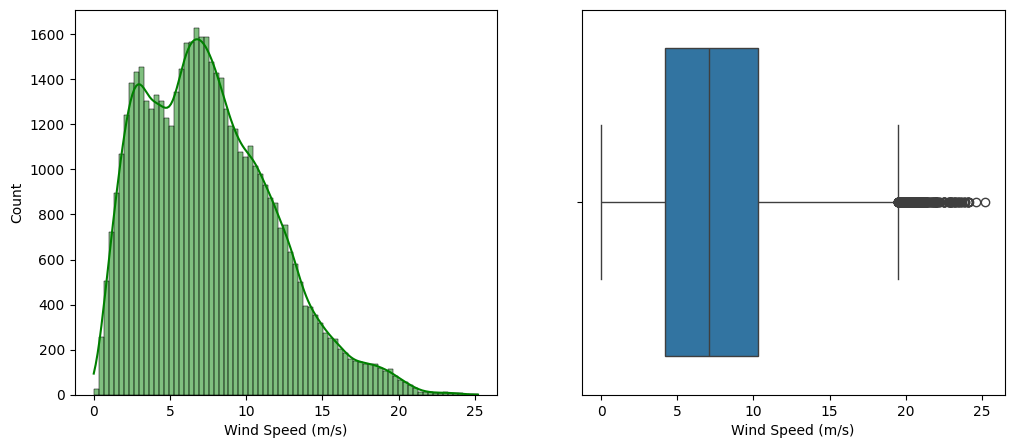

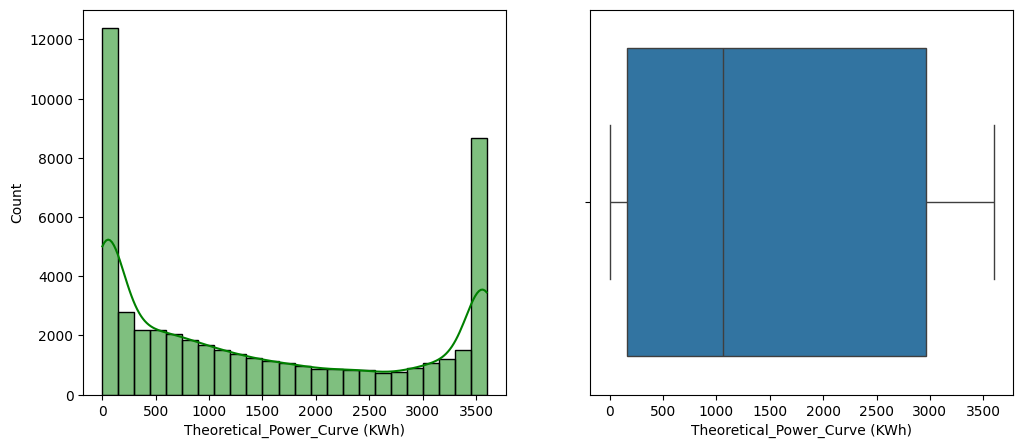

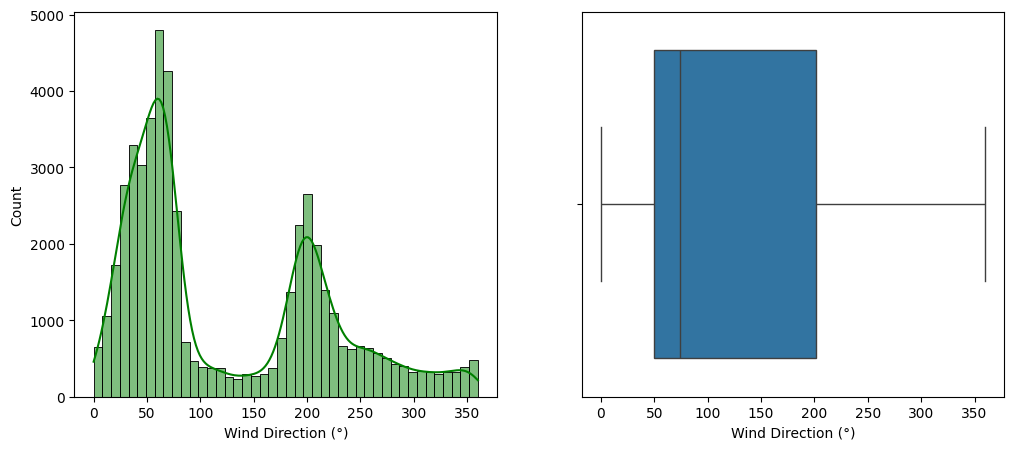

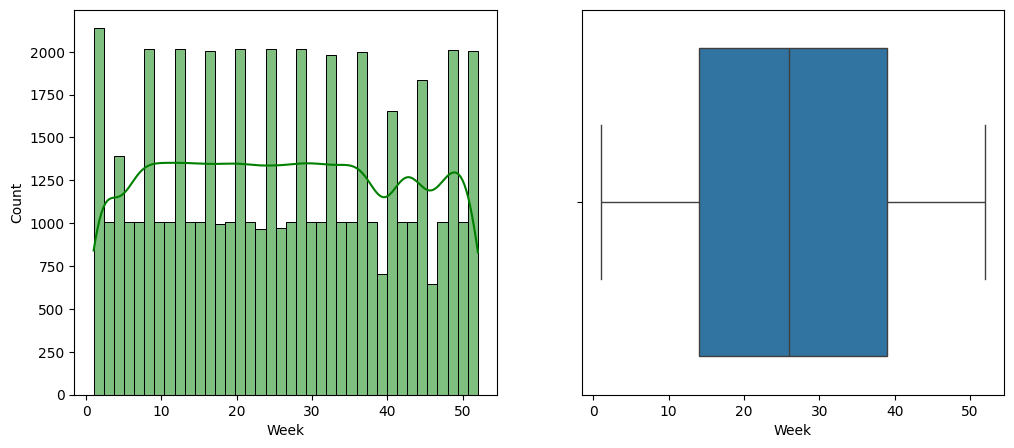

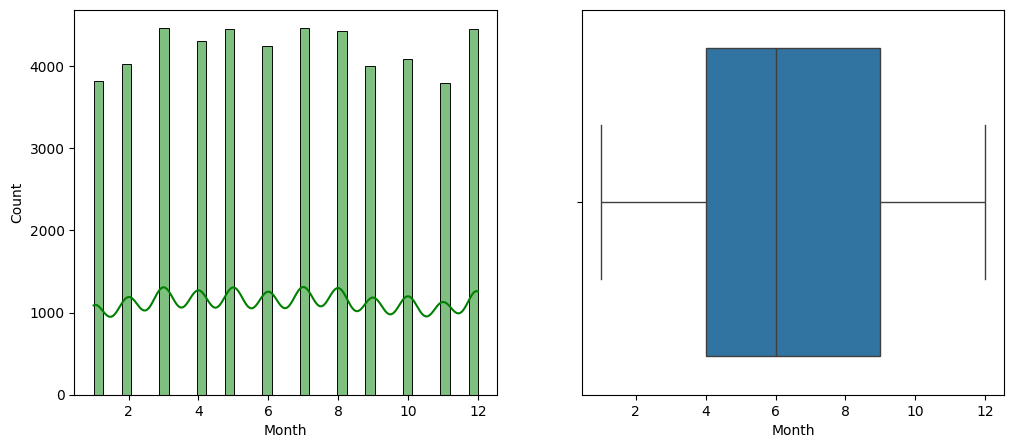

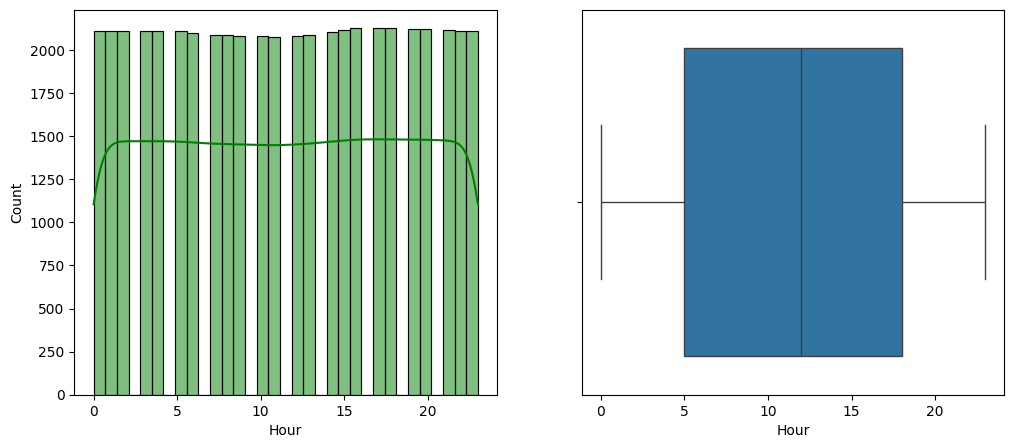

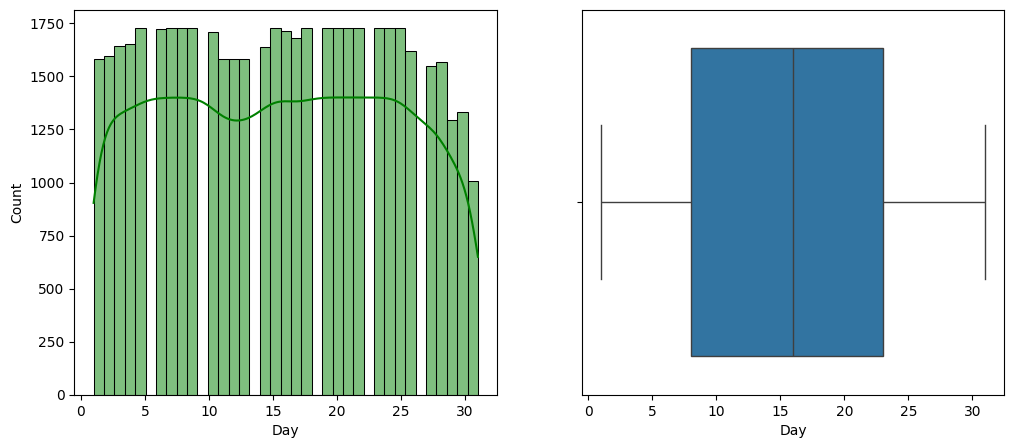

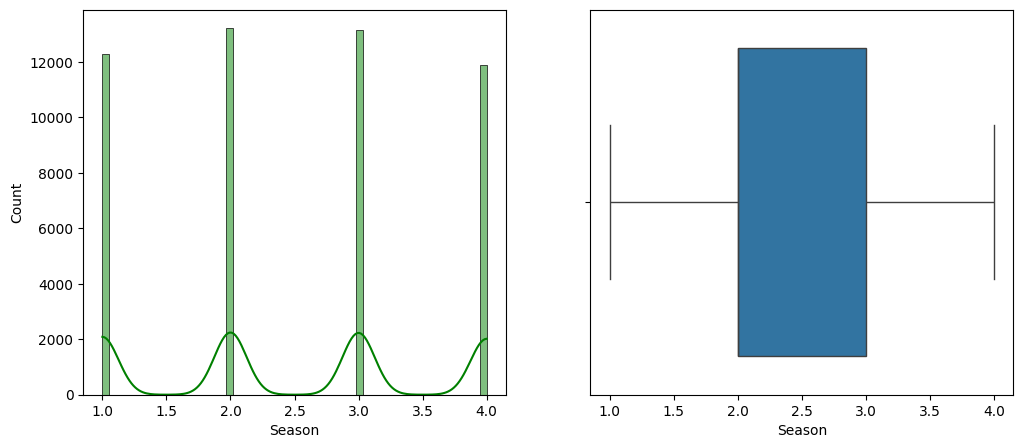

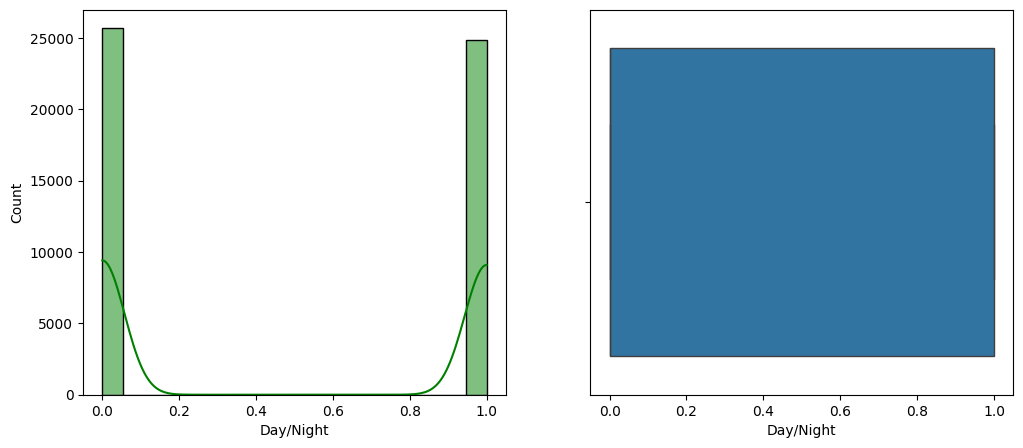

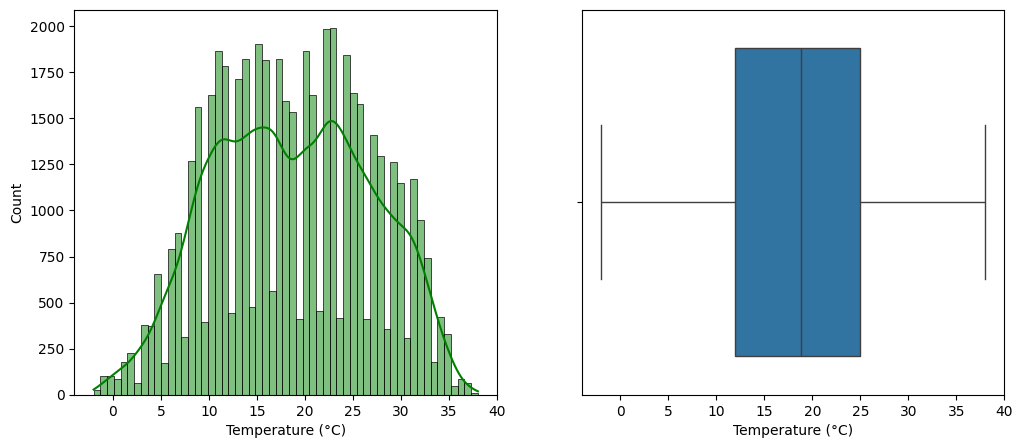

In [24]:
for column in data.describe().columns:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(data[column], ax=ax[0], color='green', kde=True)
    sns.boxplot(x=data[column], ax=ax[1])
    plt.show()

Terdapat outlier pada data kecepatan angin

##### features over time

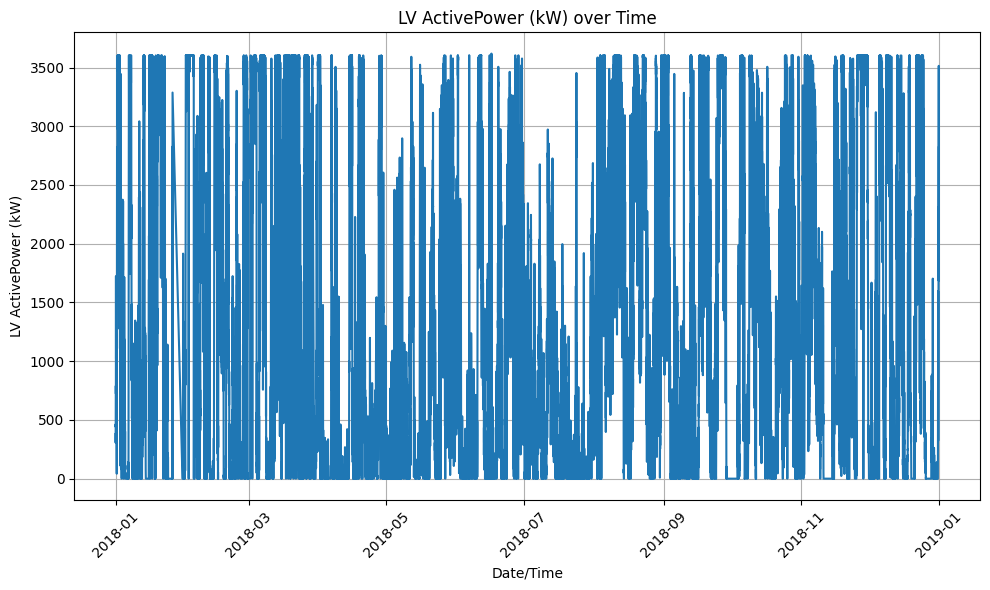

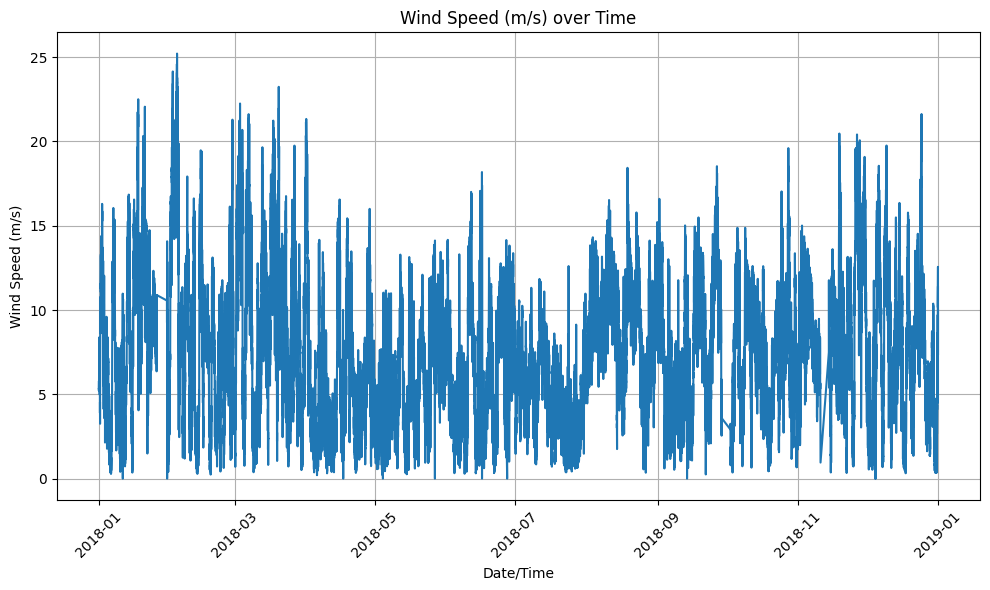

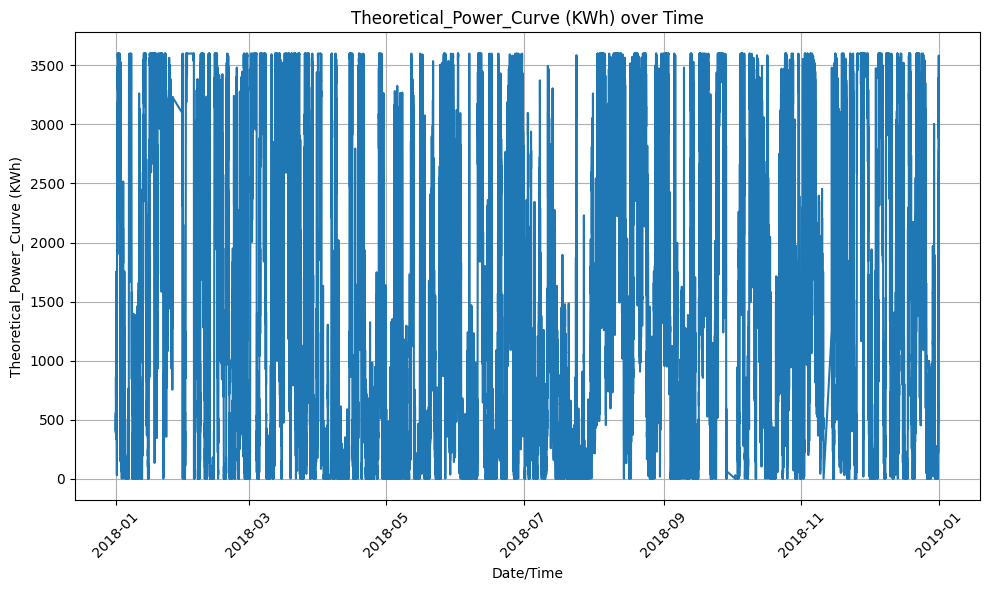

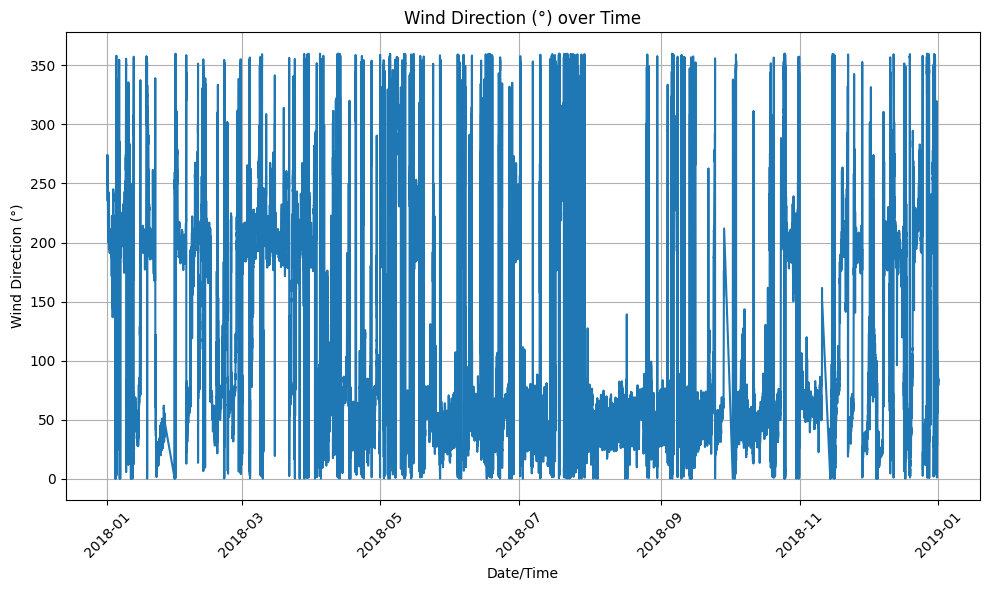

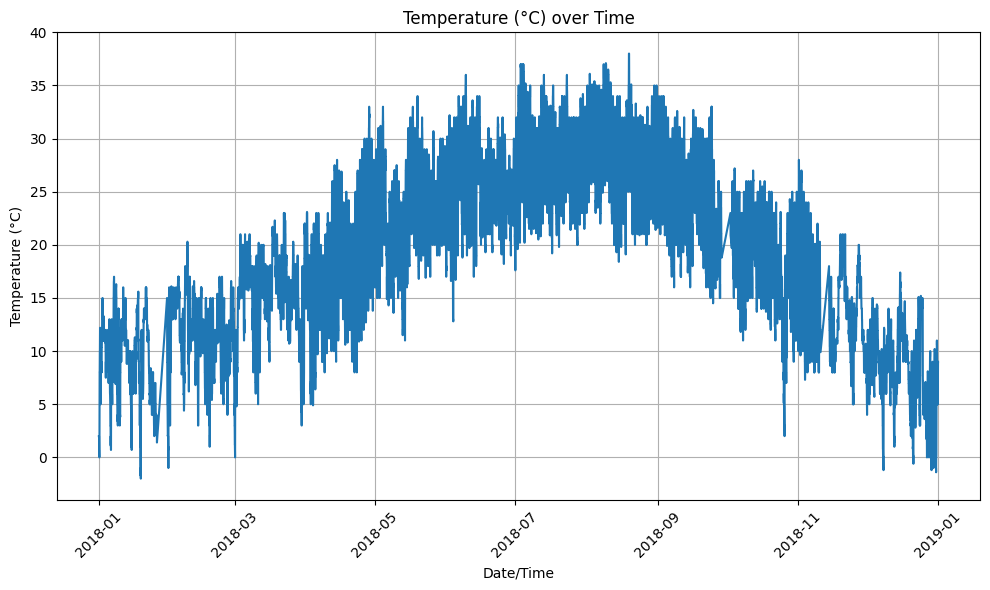

In [25]:
for column in observed_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date/Time'], data[column])
    plt.xlabel('Date/Time')
    plt.ylabel(column)
    plt.title(f'{column} over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### Distribusi Energi yang dihasilkan

In [26]:
day_power = data.groupby('Day/Night')['LV ActivePower (kW)'].sum()
day_power.index = ['Day', 'Night']
day_power.sort_values(inplace=False, ascending=False)

Night    3.546493e+07
Day      3.061238e+07
Name: LV ActivePower (kW), dtype: float64

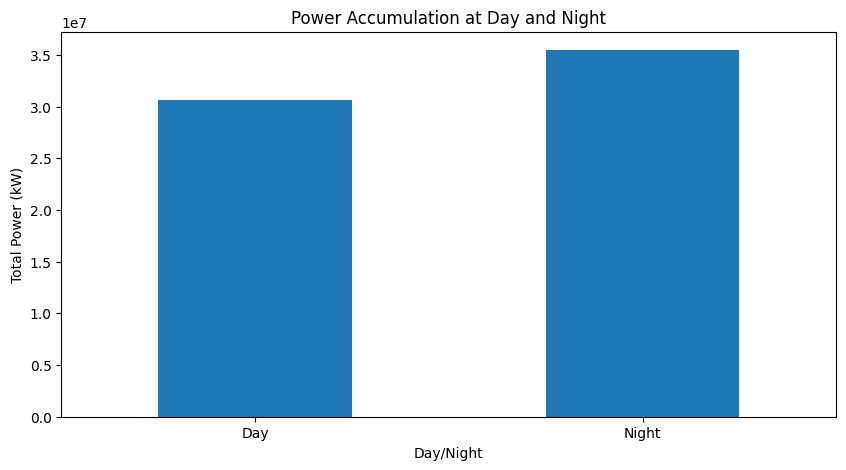

In [27]:
plt.figure(figsize=(10, 5))
day_power.plot(kind='bar')
plt.title('Power Accumulation at Day and Night')
plt.xlabel('Day/Night')
plt.ylabel('Total Power (kW)')
plt.xticks(rotation=0)
plt.show()

Energi yang dihasilkan ketika malam cenderung lebih banyak secara akumulasi

In [28]:
month_power = data.groupby('Month')['LV ActivePower (kW)'].sum()
month_power.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_power.sort_values(inplace=False, ascending=False)

August       8.753485e+06
March        8.713587e+06
November     7.169437e+06
February     6.061535e+06
October      5.749986e+06
September    5.717939e+06
December     5.233170e+06
January      5.050497e+06
June         4.225858e+06
May          3.723555e+06
April        3.548864e+06
July         2.129393e+06
Name: LV ActivePower (kW), dtype: float64

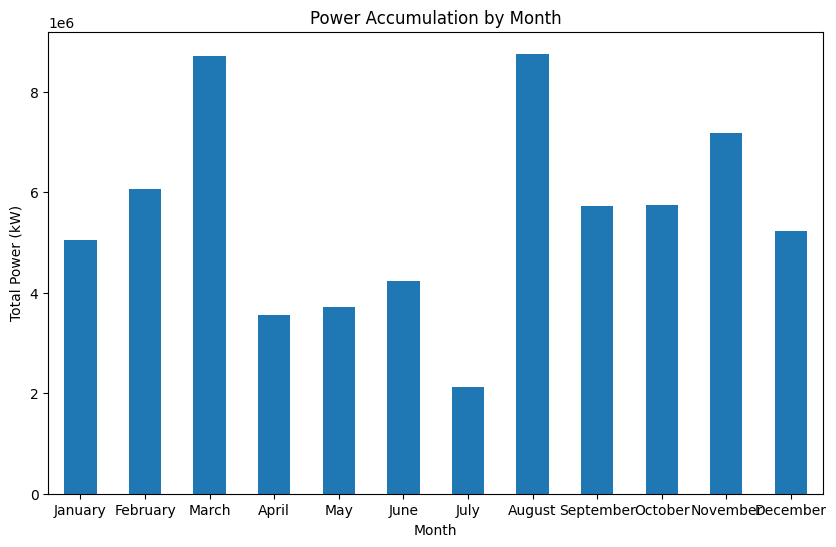

In [29]:
plt.figure(figsize=(10, 6))
month_power.plot(kind='bar')
plt.title('Power Accumulation by Month')
plt.xlabel('Month')
plt.ylabel('Total Power (kW)')
plt.xticks(rotation=0)
plt.show()

Bulan paling optimal dalam menghasilkan listrik yaitu Maret dan Agustus

In [30]:
season_power = data.groupby('Season')['LV ActivePower (kW)'].sum()
season_power.index = ['Winter', 'Spring', 'Summer', 'Autumn']
season_power.sort_values(inplace=False, ascending=False)

Autumn    1.863736e+07
Winter    1.634520e+07
Spring    1.598601e+07
Summer    1.510874e+07
Name: LV ActivePower (kW), dtype: float64

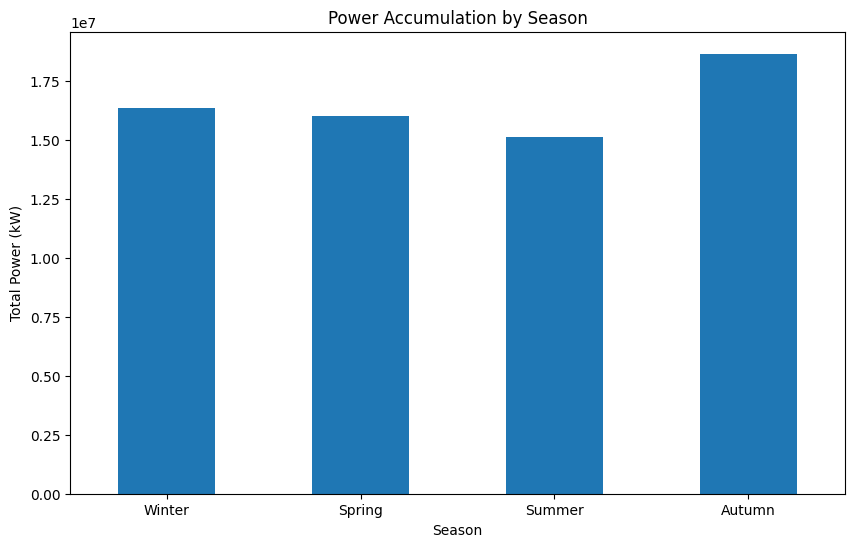

In [31]:
plt.figure(figsize=(10, 6))
season_power.plot(kind='bar')
plt.title('Power Accumulation by Season')
plt.xlabel('Season')
plt.ylabel('Total Power (kW)')
plt.xticks(rotation=0)
plt.show()

Energi yang paling banyak dihasilkan yaitu ketika musim gugur

##### Analisis kecepatan angin

In [32]:
average_wind_speed = data.groupby(['Day/Night', 'Season', 'Month'])['Wind Speed (m/s)'].mean().unstack()
average_wind_speed

Month                   1         2          3         4         5         6   \
Day/Night Season                                                                
0         1       7.955792  8.090955        NaN       NaN       NaN       NaN   
          2            NaN       NaN   8.832904  5.846243  5.764027       NaN   
          3            NaN       NaN        NaN       NaN       NaN  6.184903   
          4            NaN       NaN        NaN       NaN       NaN       NaN   
1         1       8.951236  9.051782        NaN       NaN       NaN       NaN   
          2            NaN       NaN  10.629837  5.859258  5.997284       NaN   
          3            NaN       NaN        NaN       NaN       NaN  6.588376   
          4            NaN       NaN        NaN       NaN       NaN       NaN   

Month                   7         8         9         10        11        12  
Day/Night Season                                                              
0         1            NaN       NaN       NaN       NaN       NaN  7.392984  
          2            NaN       NaN       NaN       NaN       NaN       NaN  
          3       4.928012  8.954832       NaN       NaN       NaN       NaN  
          4            NaN       NaN  7.262080  7.240874  8.956708       NaN  
1         1            NaN       NaN       NaN       NaN       NaN  7.333986  
          2            NaN       NaN       NaN       NaN       NaN       NaN  
          3       4.984470  9.837236       NaN       NaN       NaN       NaN  
          4            NaN       NaN  7.930648  7.793855  9.681203       NaN

dapat dilihat pada waktu yang maksimal dalam menghasilkan energi, angin berhembus dengan kencang

Wind Speed (m/s) dan Theoretical_Power_Curve (KWh)

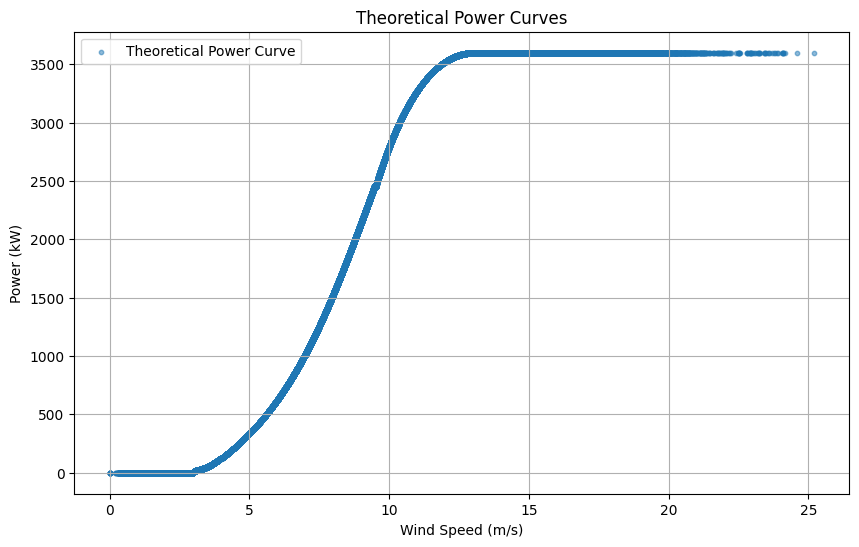

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Wind Speed (m/s)'], data['Theoretical_Power_Curve (KWh)'], s=10, alpha=0.5, label='Theoretical Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power Curves')
plt.legend()
plt.grid(True)
plt.show()

Wind Speed (m/s) dan LV ActivePower (kW)

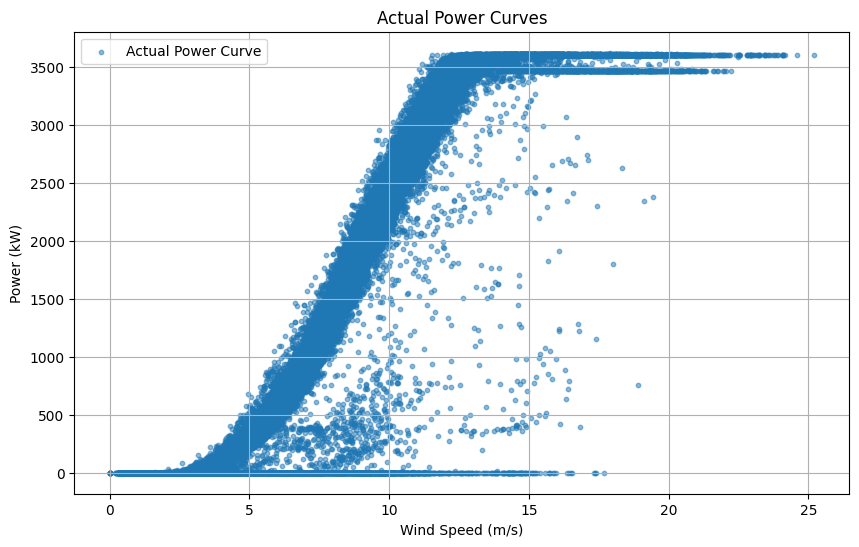

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Wind Speed (m/s)'], data['LV ActivePower (kW)'], s=10, alpha=0.5, label='Actual Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Actual Power Curves')
plt.legend()
plt.grid(True)
plt.show()

Dari kurva yang terbentuk, dapat dilihat adanya batas kecepatan angin minimum dan maksimum agar turbin dapat memproduksi energi listrik

In [35]:
min_speed = data[data['Theoretical_Power_Curve (KWh)'] > 0]['Wind Speed (m/s)'].min()
min_speed = round(min_speed, 1)
print("Minimum Wind Speed:", min_speed)

# mencari kecepatan minimum yang dapat mencapai daya maksimum
max_power = data['LV ActivePower (kW)'].max()
min_speed_max_power = data[data['LV ActivePower (kW)'] == max_power]['Wind Speed (m/s)'].min()
min_speed_max_power = round(min_speed_max_power, 1)
print("Minimum Wind Speed to reach Maximum Power:", min_speed_max_power)

Minimum Wind Speed: 3.0
Minimum Wind Speed to reach Maximum Power: 17.9


##### Analisis arah angin

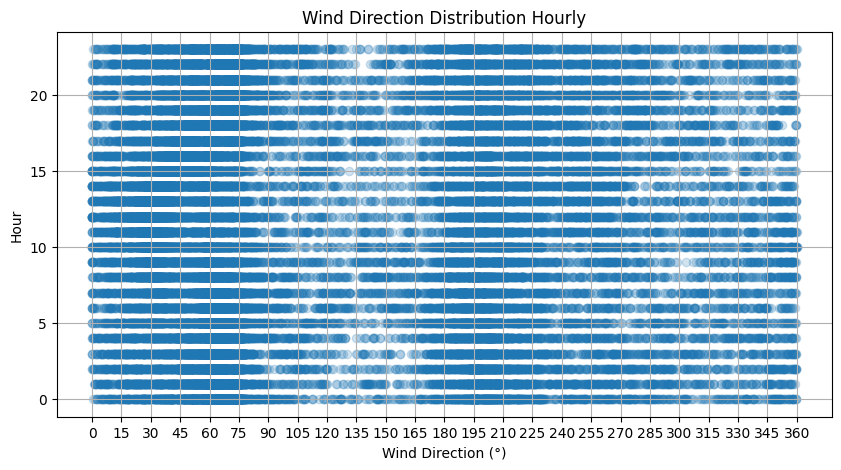

In [36]:
# Distribusi arah angin berdasarkan jam
plt.figure(figsize=(10, 5))
plt.scatter(data['Wind Direction (°)'], data['Hour'], alpha=0.2)
plt.title('Wind Direction Distribution Hourly')
plt.xlabel('Wind Direction (°)')
plt.xticks(list(range(0, 365, 15)))
plt.ylabel('Hour')
plt.grid(True)
plt.show()

Dapat dilihat bahwa mekanisme turbin menangkap hampir seluruh arah angin (0-360 derajat)

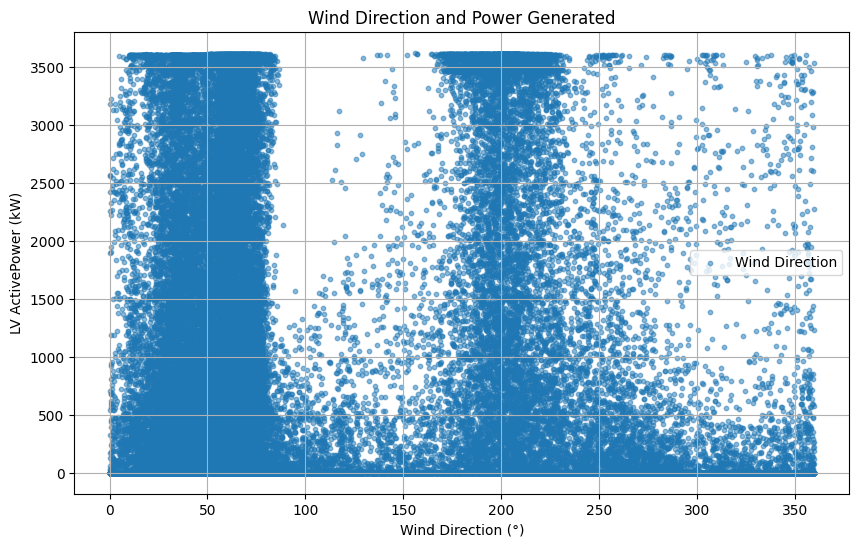

In [37]:
# Wind Direction and Actual Power
plt.figure(figsize=(10, 6))
plt.scatter(data['Wind Direction (°)'], data['LV ActivePower (kW)'], s=10, alpha=0.5, label='Wind Direction')
plt.xlabel('Wind Direction (°)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Wind Direction and Power Generated')
plt.legend()
plt.grid(True)
plt.show()

Dari grafik dapat dilihat bahwa terdapat arah angin yang paling optimal yaitu disekitar 30-75 derajat dan 180 - 210 derajat.

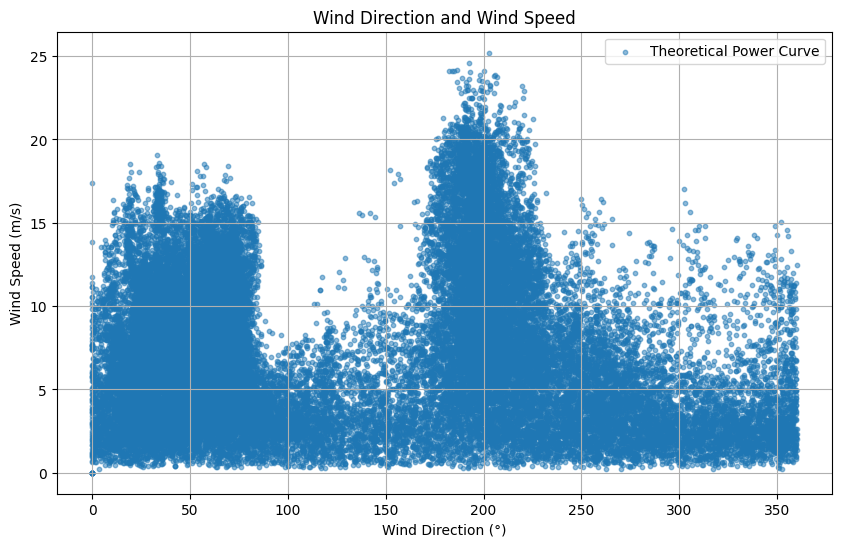

In [38]:
# Wind speed and Wind Direction
plt.figure(figsize=(10, 6))
plt.scatter(data['Wind Direction (°)'], data['Wind Speed (m/s)'], s=10, alpha=0.5, label='Theoretical Power Curve')
plt.xlabel('Wind Direction (°)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Direction and Wind Speed')
plt.legend()
plt.grid(True)
plt.show()

Jika dihubungkan dengan grafik sebelumnya, dapat dilihat bahwa pada arah angin yang menghasilkan energi maksimal juga memiliki kecepatan angin tinggi.

Hal ini juga mengindikasikan penempatan turbin yang optimal dengan kondisi angin pada wilayah Izmir, Turki

##### Heatmap

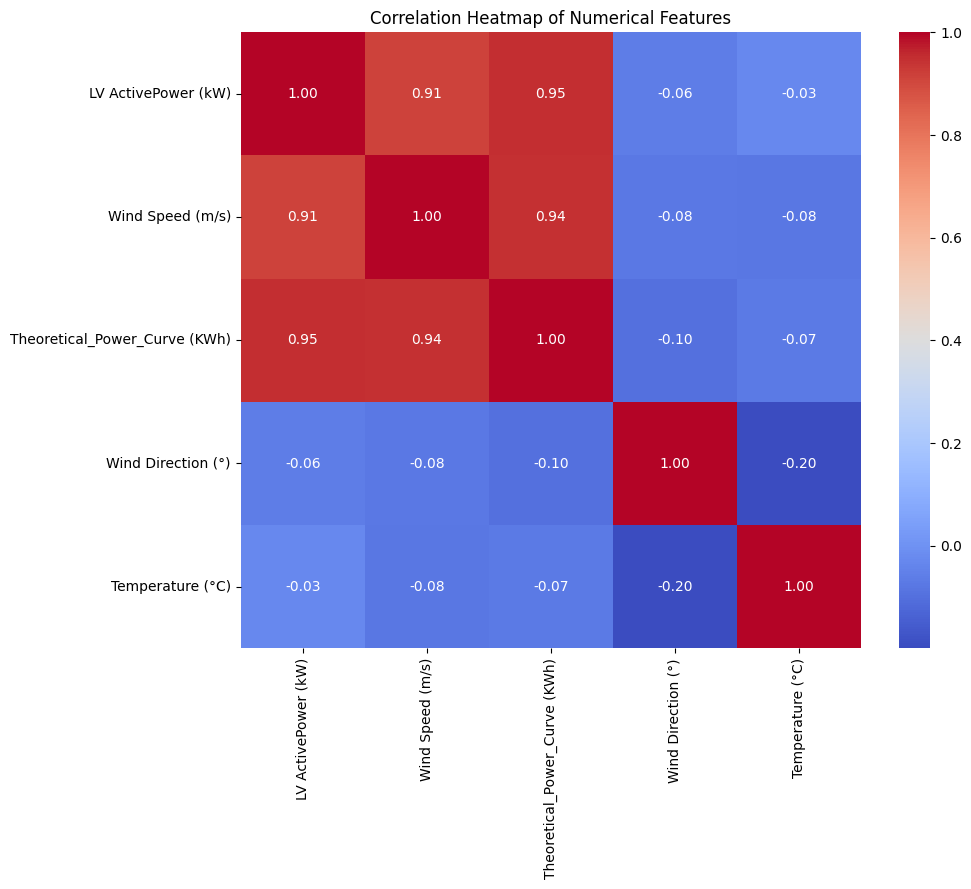

In [39]:
data_numeric = data[observed_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Dari heatmap, fitur yang paling signifikan terhadap PCOS_Diagnosis yaitu Menstrual_Irregularity dan BMI.

# Data Preparation

In [40]:
data = data.set_index('Date/Time')
data.head()

LV ActivePower (kW)  Wind Speed (m/s)  \
Date/Time                                                    
2018-01-01 00:00:00           380.047791          5.311336   
2018-01-01 00:10:00           453.769196          5.672167   
2018-01-01 00:20:00           306.376587          5.216037   
2018-01-01 00:30:00           419.645905          5.659674   
2018-01-01 00:40:00           380.650696          5.577941   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  Week  \
Date/Time                                                                      
2018-01-01 00:00:00                     416.328908          259.994904     1   
2018-01-01 00:10:00                     519.917511          268.641113     1   
2018-01-01 00:20:00                     390.900016          272.564789     1   
2018-01-01 00:30:00                     516.127569          271.258087     1   
2018-01-01 00:40:00                     491.702972          265.674286     1   

                     Month  Hour  Day  Season  Day/Night  Temperature (°C)  
Date/Time                                                                   
2018-01-01 00:00:00      1     0    1       1          1               2.0  
2018-01-01 00:10:00      1     0    1       1          1               2.0  
2018-01-01 00:20:00      1     0    1       1          1               2.0  
2018-01-01 00:30:00      1     0    1       1          1               2.0  
2018-01-01 00:40:00      1     0    1       1          1               2.0

### Normalisasi

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[observed_columns])
data_scaled_observed = scaler.transform(data[observed_columns])

data_scaled = pd.DataFrame(data_scaled_observed, columns=observed_columns, index=data.index)
data_scaled = pd.concat([data_scaled, data.drop(observed_columns, axis=1)], axis=1)

data_scaled.head()


LV ActivePower (kW)  Wind Speed (m/s)  \
Date/Time                                                    
2018-01-01 00:00:00            -0.706800         -0.531476   
2018-01-01 00:10:00            -0.650629         -0.446115   
2018-01-01 00:20:00            -0.762933         -0.554021   
2018-01-01 00:30:00            -0.676629         -0.449071   
2018-01-01 00:40:00            -0.706341         -0.468406   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  \
Date/Time                                                                
2018-01-01 00:00:00                      -0.786435            1.458725   
2018-01-01 00:10:00                      -0.710712            1.551254   
2018-01-01 00:20:00                      -0.805023            1.593244   
2018-01-01 00:30:00                      -0.713483            1.579260   
2018-01-01 00:40:00                      -0.731337            1.519504   

                     Temperature (°C)  Week  Month  Hour  Day  Season  \
Date/Time                                                               
2018-01-01 00:00:00         -2.054328     1      1     0    1       1   
2018-01-01 00:10:00         -2.054328     1      1     0    1       1   
2018-01-01 00:20:00         -2.054328     1      1     0    1       1   
2018-01-01 00:30:00         -2.054328     1      1     0    1       1   
2018-01-01 00:40:00         -2.054328     1      1     0    1       1   

                     Day/Night  
Date/Time                       
2018-01-01 00:00:00          1  
2018-01-01 00:10:00          1  
2018-01-01 00:20:00          1  
2018-01-01 00:30:00          1  
2018-01-01 00:40:00          1

### Splitting Data

 Dataset dibagi menjadi 80% data pelatihan dan 20% data pengujian atau validation data untuk lebih menilai kinerja model

In [42]:
X = data.drop(columns=['LV ActivePower (kW)'])
y = data['LV ActivePower (kW)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')

Shape of training data: (40424, 10)
Shape of test data: (10106, 10)


# Modelling

In [43]:
!pip install xgboost catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
    --------------------------------------- 2.1/102.5 MB 16.8 MB/s eta 0:00:06
   -- ------------------------------------- 5.8/102.5 MB 16.8 MB/s eta 0:00:06
   --- ------------------------------------ 8.7/102.5 MB 16.3 MB/s eta 0:00:06
   ---- ----------------------------------- 12.6/102.5 MB 16.4 MB/s eta 0:00:06
   ------ --------------------------------- 16.0/102.5 MB 16.2 MB/s eta 0:00:06
   ------- -------------------------------- 19.1/102.5 MB 16.1 MB/s eta 0:00:06
   -------- ------------------------------- 22.5/102.5 MB 16.0 MB/s eta 0:00:05
   ---------- ----------------------------- 25.7/102.5 MB 16.1 MB/s eta 0:00:05
   ----------- ---------------------------- 29.1/102.5 MB 16.0 MB/s eta 0:00:05
   ------------ --------------------------- 32.2/102.5 MB 16.0 MB/s eta 0:00:05
   ------------- -------------------------- 35.1/102.5 MB 15.8 MB/s


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from catboost import CatBoostRegressor

### Base Models

In [45]:
models=[
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

In [46]:
model_name=[]
r2score=[]
rmse=[]
mae=[]
mape=[]

for model in models:
    model_name.append(model.__class__.__name__)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    r2score.append(r2_score(y_test,y_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    mae.append(mean_absolute_error(y_test,y_pred))
    mape.append(mean_absolute_percentage_error(y_test,y_pred))

Learning rate set to 0.073456
0:	learn: 1226.5893886	total: 159ms	remaining: 2m 39s
1:	learn: 1149.0229629	total: 166ms	remaining: 1m 22s
2:	learn: 1074.8535131	total: 172ms	remaining: 57.3s
3:	learn: 1006.2142155	total: 180ms	remaining: 44.8s
4:	learn: 942.8248761	total: 187ms	remaining: 37.3s
5:	learn: 885.9439000	total: 197ms	remaining: 32.6s
6:	learn: 832.4307825	total: 206ms	remaining: 29.3s
7:	learn: 782.8902224	total: 213ms	remaining: 26.4s
8:	learn: 738.4497326	total: 220ms	remaining: 24.2s
9:	learn: 696.6655596	total: 226ms	remaining: 22.3s
10:	learn: 658.7493571	total: 231ms	remaining: 20.8s
11:	learn: 624.5321010	total: 238ms	remaining: 19.6s
12:	learn: 593.3842127	total: 245ms	remaining: 18.6s
13:	learn: 563.7855474	total: 251ms	remaining: 17.7s
14:	learn: 536.2659714	total: 257ms	remaining: 16.9s
15:	learn: 512.3021460	total: 263ms	remaining: 16.2s
16:	learn: 490.5115137	total: 270ms	remaining: 15.6s
17:	learn: 469.8559675	total: 277ms	remaining: 15.1s
18:	learn: 451.06983

In [47]:
score_df = pd.DataFrame({'model':model_name,'r2_score':r2score,'rmse':rmse,'mae':mae,'mape':mape})
score_df

model  r2_score        rmse         mae          mape
0  GradientBoostingRegressor  0.951877  286.554685  127.704954  1.544708e+17
1                        SVR  0.895137  423.000675  165.703939  2.368704e+17
2      RandomForestRegressor  0.975409  204.840539   73.304598  7.658194e+16
3           LinearRegression  0.905894  400.717686  207.776092  3.002220e+17
4        ExtraTreesRegressor  0.978224  192.760846   69.946074  7.041455e+16
5          AdaBoostRegressor  0.885727  441.571286  273.100957  1.999998e+17
6      DecisionTreeRegressor  0.956899  271.190647   88.624083  5.868942e+16
7               XGBRegressor  0.983315  168.728857   72.438996  7.046531e+16
8             XGBRFRegressor  0.946357  302.541482  123.742913  1.476884e+17
9          CatBoostRegressor  0.984670  161.733358   71.918237  7.199305e+16

# Evaluation

In [48]:
score_df.sort_values(by='r2_score',ascending=False)

model  r2_score        rmse         mae          mape
9          CatBoostRegressor  0.984670  161.733358   71.918237  7.199305e+16
7               XGBRegressor  0.983315  168.728857   72.438996  7.046531e+16
4        ExtraTreesRegressor  0.978224  192.760846   69.946074  7.041455e+16
2      RandomForestRegressor  0.975409  204.840539   73.304598  7.658194e+16
6      DecisionTreeRegressor  0.956899  271.190647   88.624083  5.868942e+16
0  GradientBoostingRegressor  0.951877  286.554685  127.704954  1.544708e+17
8             XGBRFRegressor  0.946357  302.541482  123.742913  1.476884e+17
3           LinearRegression  0.905894  400.717686  207.776092  3.002220e+17
1                        SVR  0.895137  423.000675  165.703939  2.368704e+17
5          AdaBoostRegressor  0.885727  441.571286  273.100957  1.999998e+17

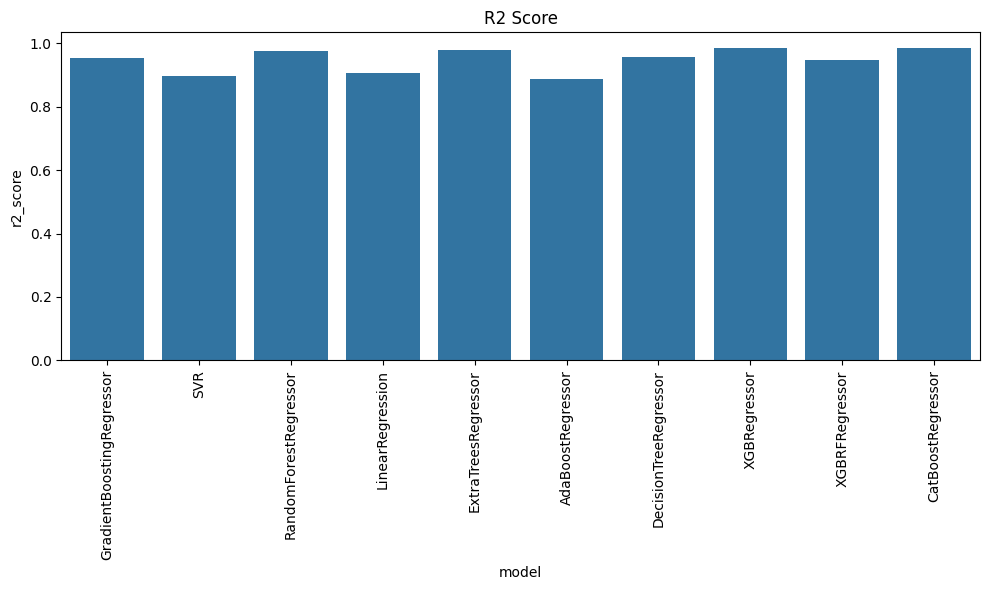

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='r2_score', data=score_df)
plt.xticks(rotation=90)
plt.title('R2 Score')
plt.tight_layout()
plt.show()

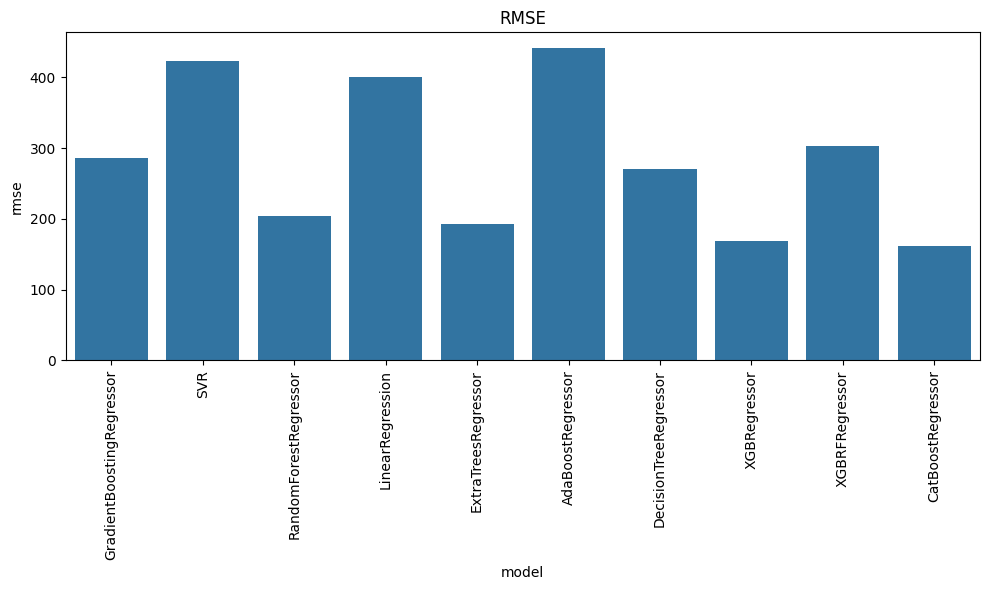

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='rmse', data=score_df)
plt.xticks(rotation=90)
plt.title('RMSE')
plt.tight_layout()
plt.show()

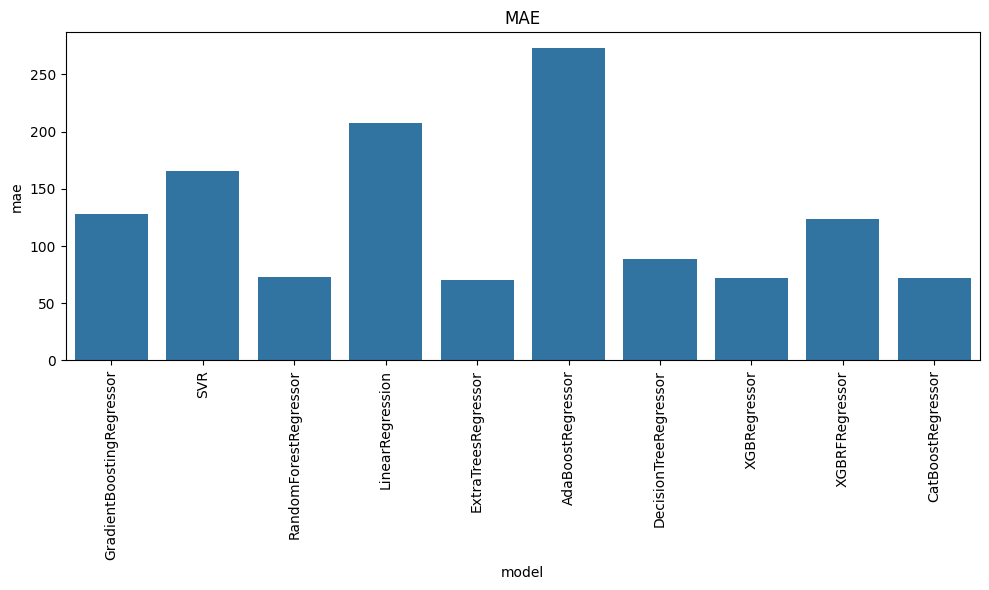

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='mae', data=score_df)
plt.xticks(rotation=90)
plt.title('MAE')
plt.tight_layout()
plt.show()

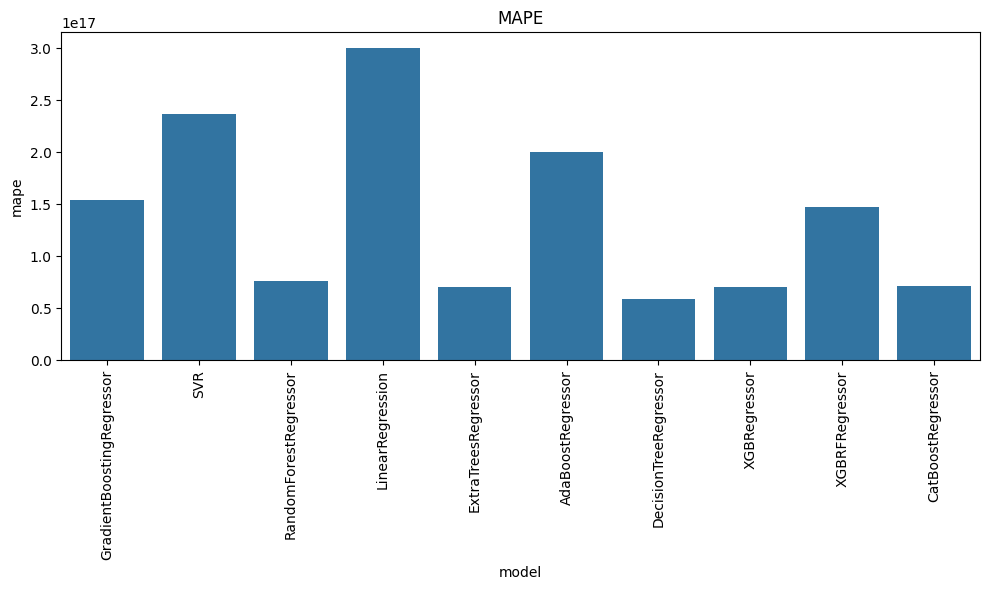

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='mape', data=score_df)
plt.xticks(rotation=90)
plt.title('MAPE')
plt.tight_layout()
plt.show()

dari analisis metrik yang diperoleh, yang paling optimal yaitu model CatBoostRegressor(random_state=42)

In [53]:
best_model = CatBoostRegressor(random_state=42)

### Fine Tuning

Dilakukan hyperparameter fine tuning untuk meningkatkan performa model

In [54]:
from sklearn.model_selection import RandomizedSearchCV

In [55]:
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [56]:
param_grid = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': [100, 200, 300, 400, 500],  # Equivalent to n_estimators
    'depth': [3, 5, 7, 9],  # Equivalent to max_depth
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bylevel': np.linspace(0.5, 1.0, 6),  # Equivalent to colsample_bytree
    'l2_leaf_reg': np.linspace(0.01, 1.0, 10),  # Equivalent to reg_lambda
    'min_child_samples': [1, 5, 10, 15],  # Equivalent to min_child_weight
}

random_search = RandomizedSearchCV(estimator=best_model,
                                 param_distributions=param_grid,
                                 n_iter=50,
                                 scoring=rmse_scorer,
                                 cv=5,
                                 verbose=1,
                                 random_state=42,
                                 n_jobs=-1
                                 )

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0:	learn: 1036.8136351	total: 19.8ms	remaining: 9.89s
1:	learn: 825.4951197	total: 39.2ms	remaining: 9.76s
2:	learn: 666.9114235	total: 61ms	remaining: 10.1s
3:	learn: 549.8195265	total: 78.6ms	remaining: 9.75s
4:	learn: 465.3509478	total: 99.5ms	remaining: 9.85s
5:	learn: 404.0175091	total: 120ms	remaining: 9.91s
6:	learn: 356.7714952	total: 139ms	remaining: 9.78s
7:	learn: 324.7490059	total: 161ms	remaining: 9.9s
8:	learn: 301.4165405	total: 180ms	remaining: 9.83s
9:	learn: 285.1864047	total: 200ms	remaining: 9.81s
10:	learn: 271.2564581	total: 220ms	remaining: 9.77s
11:	learn: 259.9853755	total: 244ms	remaining: 9.91s
12:	learn: 251.4650441	total: 264ms	remaining: 9.88s
13:	learn: 245.2685901	total: 283ms	remaining: 9.83s
14:	learn: 240.0395957	total: 300ms	remaining: 9.69s
15:	learn: 237.2260445	total: 319ms	remaining: 9.64s
16:	learn: 233.6674027	total: 335ms	remaining: 9.51s
17:	learn: 231.0430543	total: 354ms	remainin

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000217A0EDD7C0>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'depth': [3, 5, 7, 9],
                                        'iterations': [100, 200, 300, 400, 500],
                                        'l2_leaf_reg': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'min_child_samples': [1, 5, 10, 15],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [57]:
best_params = random_search.best_params_
best_params

{'subsample': 0.8,
 'min_child_samples': 1,
 'learning_rate': 0.23555555555555557,
 'l2_leaf_reg': 1.0,
 'iterations': 500,
 'depth': 9,
 'colsample_bylevel': 0.9}

In [58]:
best_score = random_search.best_score_
best_score

-142.719352274941

In [59]:
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train,verbose=False)
y_pred_test= best_model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_test))

R2 Score: 0.9881578176597767
RMSE: 142.14934648611487
MAE: 59.72447828787168
MAPE: 5.304711773256123e+16


### Prediction Plot

In [60]:
y_pred = best_model.predict(X_test)

In [61]:
data_pred = pd.DataFrame(y_pred, columns=['Predictions'])
data_pred['LV ActivePower (kW)'] = y_test.values
data_pred['Date/Time'] = X_test.index
data_pred = pd.merge(X_test, data_pred, left_index=True, right_on='Date/Time', how='inner')
data_pred.head()

Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  Wind Direction (°)  Week  \
0         11.632760                    3452.918718          188.499802     9   
1         10.345970                    2989.120313          190.715607     9   
2          6.430618                     779.117347           29.279140    52   
3          7.952174                    1502.728868           49.509399    16   
4          5.906481                     593.890170          278.626190    51   

   Month  Hour  Day  Season  Day/Night  Temperature (°C)  Predictions  \
0      3    10    2       2          0              14.0  3185.915610   
1      3    11    2       2          0              15.0  2730.236904   
2     12     1   30       1          1               1.0   -17.834068   
3      4     4   18       2          1              11.0  1356.581675   
4     12    23   23       1          1               4.0   529.814754   

   LV ActivePower (kW)           Date/Time  
0          3348.910889 2018-03-02 10:40:00  
1          2647.506104 2018-03-02 11:00:00  
2             0.000000 2018-12-30 01:20:00  
3          1334.573975 2018-04-18 04:50:00  
4           533.002808 2018-12-23 23:20:00

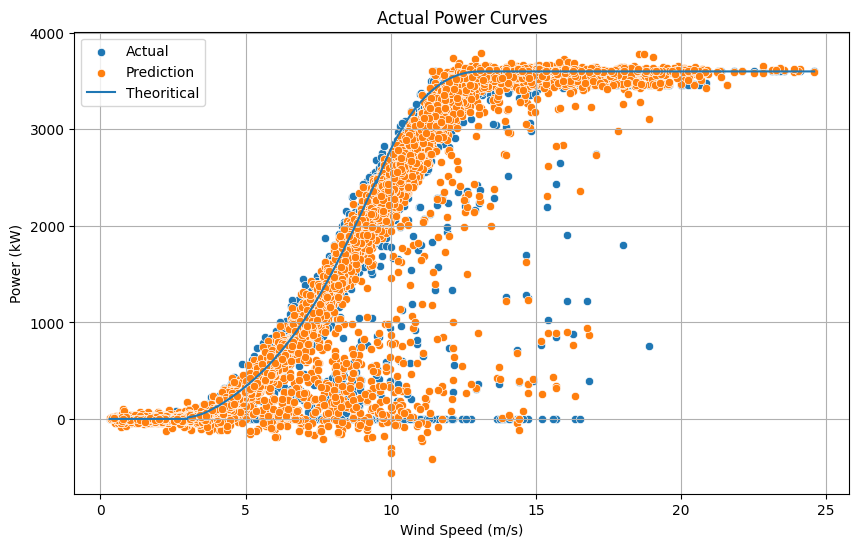

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=data_pred, label='Actual')
sns.scatterplot(x='Wind Speed (m/s)', y='Predictions', data=data_pred, label='Prediction')
sns.lineplot(x='Wind Speed (m/s)', y='Theoretical_Power_Curve (KWh)', data=data_pred, label='Theoritical')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Actual Power Curves')
plt.legend()
plt.grid(True)
plt.show()